 Adapted from https://github.com/DeepLearningForPhysicsResearchBook/deep-learning-physics/blob/main/Exercise_10_1.ipynb
 ## Task 3
 ## Signal Classification using Dynamic Graph Convolutional Neural Networks
 After a long journey through the universe before reaching the earth, the cosmic particles interact with the galactic magnetic field $B$.
 As these particles carry a charge $q$ they are deflected in the field by the Lorentz force $F = q \cdot v × B$.
 Sources of cosmic particles are located all over the sky, thus arrival distributions of the cosmic particles are isotropic in general. However, particles originating from the same source generate on top of the isotropic
 arrival directions, street-like patterns from galactic magnetic field deflections.

 In this tasks we want to classify whether a simulated set of $500$ arriving cosmic particles contains street-like patterns (signal), or originates from an isotropic background.

 Training graph networks can be computationally demanding, thus, we recommend to use a GPU for this task.

In [1]:
import torch
from torch import nn
from torch_geometric.data import Data, Batch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from utils import CosmicRayDS

ds = CosmicRayDS(".")
n_test = 10000
ds_train, ds_test = ds[:-n_test], ds[-n_test:]

/home/mscham/deep-learning-physics/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## Task 3.1
 Extract a single event from the test dataset and inspect it.
 Plot an example sky map using the `skymap` function from `utils`

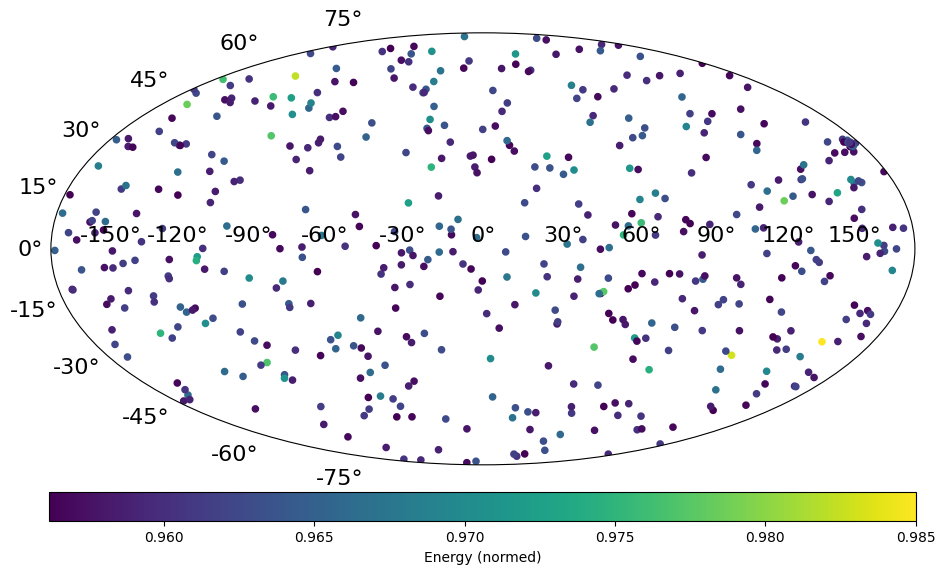

In [2]:
from utils import skymap

event0 = ds_test[0]
fig = skymap(event0.pos, c=event0.x, zlabel="Energy (normed)", title="Event 0")

 ## Task 3.2
 Generate edges for the event using `knn_graph`.
 Plot the edges by passing the `edge_index` to the `skymap` function. How does the number of edges scale with the $k$?

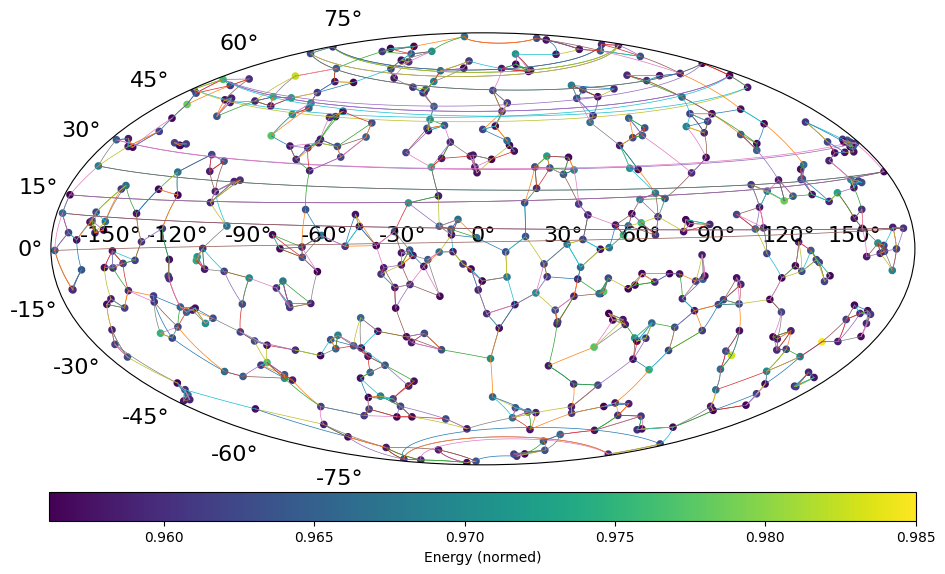

In [3]:
from torch_geometric.nn import knn_graph


fig = skymap(
    event0.pos,
    c=event0.x,
    edge_index=knn_graph(event0.pos, k=3),
    zlabel="Energy (normed)",
    title="Event 0",
)
# -> k*num_nodes

 ## Task 3.3
 Write a class to return a simple Feed-Forward-Network (FFN) for a given number inputs and outputs. (3 layers, 20 hidden nodes, BatchNorm, LeakyReLU)

In [4]:
class FFN(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=20):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Linear(n_hidden, n_out),
        )

    def forward(self, *args, **kwargs):
        return self.seq(*args, **kwargs)

 ## Task 3.4
 GNNs classifiers are frequently build in a two step process: First MessagePassingLayers( aka Graph [Convolutional Layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) ) update the nodes. These exploit the local information. Then, the nodes are aggregated using [Pooling Layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#pooling-layers), reducing the graph to a single feature vector. This feature vector is then passed through a FFN to get the classification output.
 Have a look at the documentation of [EdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.EdgeConv) and [DynamicEdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.DynamicEdgeConv).
 What is the difference?
 -> `EdgeConv` requires a `edge_index` while `DynamicEdgeConv` constructs the `edge_index` on the feature space.
 What the input space of the `nn` passed to EdgeConv?
 -> 2* num_features
 Implement a GNN class with three MPL (not MLP!) using EdgeConv
 and DynamicEdgeConv. For the first MPL, we want to construct
 the `edge_index` on the feature space.
 Use both the energies of the particles (`batch.x`) as well as their positions (`batch.pos`) as an input to the first MPL.
 For the other two layer we may (or may not) choose to construct the `edge_index` on the feature space.
 > Sidenote: Running `knn` multiple times per forward-pass might be quite expensive, depending on the number of nodes and the dimensionality of the space.
 After the MPLs apply a `global_X_pool` and pass the result through a FFN projecting to a single node.

In [5]:
from torch_geometric.nn import knn_graph, EdgeConv, DynamicEdgeConv, global_add_pool


class GNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = EdgeConv(FFN(4 * 2, 5))
        self.conv2 = DynamicEdgeConv(FFN(5 * 2, 5), k=5)
        self.conv3 = DynamicEdgeConv(FFN(5 * 2, 5), k=5)
        self.out = FFN(5, 1)

    def forward(self, batch: Batch):
        # We run knn on the positions
        # knn needs to know about the batches, otherwise it connects
        # points from different events
        edge_index = knn_graph(batch.pos, batch=batch.batch, k=10)
        x = torch.hstack([batch.x, batch.pos])
        x = self.conv1(x, edge_index=edge_index)
        x = self.conv2(x)
        # edge_index = knn_graph(x, batch=batch.batch, k=10)
        x = self.conv3(x)
        x = global_add_pool(x, batch.batch)
        x = self.out(x)
        return x.squeeze()

 ## Task 3.5
 Fill in  the gaps to implement a training loop.
 > The [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) is recommended as it combines a Sigmoid layer and the `BCELoss`.

In [6]:
from torch_geometric.loader import DataLoader
from utils import metric_aggr

device = torch.device("cuda")
loader = DataLoader(ds_train, batch_size=64, shuffle=True)
model = GNN().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_f = nn.BCEWithLogitsLoss()

for iepoch in range(1):
    for batch in tqdm(loader):
        optim.zero_grad()
        batch = batch.to(device)
        output = model(batch)
        loss = loss_f(output, batch.y)
        loss.backward()
        optim.step()
        metric_aggr("loss", float(loss.detach().cpu()))

  3%|▎         | 21/625 [00:04<01:48,  5.57it/s]

loss: 0.6645565429804264


  7%|▋         | 41/625 [00:07<01:44,  5.58it/s]

loss: 0.6449118235628702


 10%|▉         | 61/625 [00:11<01:41,  5.56it/s]

loss: 0.6319714032506454


 13%|█▎        | 81/625 [00:15<01:37,  5.58it/s]

loss: 0.6215692416022648


 16%|█▌        | 101/625 [00:18<01:34,  5.57it/s]

loss: 0.6065046925839852


 19%|█▉        | 121/625 [00:22<01:30,  5.57it/s]

loss: 0.5953601544650156


 23%|██▎       | 141/625 [00:25<01:26,  5.57it/s]

loss: 0.579145123474882


 26%|██▌       | 161/625 [00:29<01:23,  5.57it/s]

loss: 0.5637561688912683


 29%|██▉       | 181/625 [00:33<01:19,  5.56it/s]

loss: 0.5551580629107775


 32%|███▏      | 201/625 [00:36<01:16,  5.57it/s]

loss: 0.5484844361330034


 35%|███▌      | 221/625 [00:40<01:12,  5.57it/s]

loss: 0.5377445230886224


 39%|███▊      | 241/625 [00:43<01:09,  5.56it/s]

loss: 0.531872220657533


 42%|████▏     | 261/625 [00:47<01:05,  5.57it/s]

loss: 0.5131592750869458


 45%|████▍     | 281/625 [00:51<01:01,  5.56it/s]

loss: 0.5043025920924264


 48%|████▊     | 301/625 [00:54<00:58,  5.56it/s]

loss: 0.5028966648387723


 51%|█████▏    | 321/625 [00:58<00:54,  5.57it/s]

loss: 0.5017985465354287


 55%|█████▍    | 341/625 [01:01<00:50,  5.57it/s]

loss: 0.4879753844696097


 58%|█████▊    | 361/625 [01:05<00:47,  5.57it/s]

loss: 0.4656340374451247


 61%|██████    | 381/625 [01:09<00:43,  5.57it/s]

loss: 0.4694029817037517


 64%|██████▍   | 401/625 [01:12<00:43,  5.15it/s]

loss: 0.4634083072982321


 67%|██████▋   | 421/625 [01:16<00:37,  5.46it/s]

loss: 0.45593800410279073


 71%|███████   | 441/625 [01:20<00:33,  5.46it/s]

loss: 0.4570111374785483


 74%|███████▍  | 461/625 [01:23<00:30,  5.46it/s]

loss: 0.43875042358922656


 77%|███████▋  | 481/625 [01:27<00:26,  5.46it/s]

loss: 0.4296480832086672


 80%|████████  | 501/625 [01:31<00:22,  5.46it/s]

loss: 0.4216897448939562


 83%|████████▎ | 521/625 [01:34<00:19,  5.46it/s]

loss: 0.40932817737193544


 87%|████████▋ | 541/625 [01:38<00:15,  5.45it/s]

loss: 0.4108964928644127


 90%|████████▉ | 561/625 [01:42<00:11,  5.46it/s]

loss: 0.4058331656095106


 93%|█████████▎| 581/625 [01:45<00:08,  5.46it/s]

loss: 0.4017443952165195


 96%|█████████▌| 601/625 [01:49<00:04,  5.45it/s]

loss: 0.3965340470593219


 99%|█████████▉| 621/625 [01:53<00:00,  5.46it/s]

loss: 0.38564528946153587


100%|██████████| 625/625 [01:53<00:00,  5.48it/s]


 ## Task 3.6
 Collect the outputs for the test set.

In [7]:
loader = DataLoader(ds_test, batch_size=6, shuffle=True)
model.eval()
output_list = []
with torch.no_grad():
    for batch in tqdm(loader):
        optim.zero_grad()
        batch = batch.to(device)
        output_list.append(torch.vstack([batch.y.float(), model(batch)]))
ytrue, yhat = torch.hstack(output_list).cpu().numpy()

100%|██████████| 1667/1667 [00:33<00:00, 50.48it/s]


 ## Task 3.7
 Evalutate the model performance on the test set by computing the AUC.

In [8]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytrue, yhat)

0.91326766

 ## Task 3.8 - Bonus/Open end
 Optimize the model for AUC and speed.